# Thresholding and histogram analysis

## Setup

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
from skimage.color import rgb2gray,rgb2hsv, label2rgb
from skimage import color, filters, feature, measure, morphology, transform,io, util,exposure
from scipy import ndimage

In [3]:
import os.path, os, re

## Some utility functions

In [4]:
import math

In [5]:
def plot_all(images,fig_ratio = (3,3)): 
    n = len(images) 
    a = math.ceil(math.sqrt(n)) 
    b = math.ceil(n/a)
    ra,rb = fig_ratio
    fig, ax = plt.subplots(a,b,figsize=(ra*a,rb*b))
    ax = ax.flat
    for i in range(len(ax)):
        ax[i].axis("off")
    for i in range(n):
        if images[i].ndim == 2:
            ax[i].imshow(images[i],cmap="gray")
        else:
            ax[i].imshow(images[i])
    plt.tight_layout()
    plt.show()

## Loading the images

In [6]:
# img_path = "drive/MyDrive/level_images/"
img_path = "level_images/"
images = list(filter(lambda x : re.match(".*\.(jpg|PNG|png)",x), os.listdir(img_path)))
img = [
        util.img_as_ubyte(io.imread(os.path.join(img_path,image))[...,:3])
    for image in images
]

In [7]:
img_gray = [ color.rgb2gray(image) for image in img]

## Approximate Vertical  margin detection

In [8]:
from bapsap.img.utils import reduce_to_size, threshold

In [9]:
def find_approx_tube_vertical_margins(img, reduction_size=20):
    '''Returns the approximate Vertical margins of the tubes.
    Uses a binary thersholded image.
    '''
    # size of the image
    h, w = img.shape
    
#     # invert the image if overall grey sc
#     if np.mean(img)>.5:
#         util.invert(img)
        
    # Reducing the image for efficiency
    reduced = reduce_to_size(
        img, size=(reduction_size,10),
        # reducing function =  max of region - min of region
        func=lambda x, axis: np.max(x, axis=axis)-np.min(x, axis=axis)
    )
    reduced = reduced.mean(axis=1)
    
    # thresholding to find the boundary
    reduced = threshold(reduced-reduced.min(), filters.threshold_otsu)
    
    # filling the centers with white 
    # inorder to prevent spliting in the center 
    # incase of two rows of tubes
    r_h = reduced.shape[0]
    quad = r_h//4
    reduced[quad:-quad]=1
    
    # difference between original and shifted to find the points of inversion
    reduced  = reduced ^ np.roll(reduced,1)
    
    # indices of inversion
    idxs = np.argwhere(reduced)
    
    # index of the largest region
    i = np.argmax(np.diff(idxs,axis=0))
    
    margin = idxs[[i,i+1]] * h//reduction_size
    return slice(*map(int,margin))

In [10]:
margins = [find_approx_tube_vertical_margins(image,30) for image in img_gray]
margins

[slice(466, 1534, None),
 slice(466, 1534, None),
 slice(466, 1534, None),
 slice(504, 1656, None),
 slice(466, 1534, None),
 slice(466, 1534, None),
 slice(34, 974, None),
 slice(466, 1534, None),
 slice(504, 1728, None),
 slice(121, 1051, None),
 slice(466, 1534, None),
 slice(466, 1534, None),
 slice(504, 1656, None),
 slice(504, 1656, None),
 slice(466, 1534, None)]

In [11]:
img_cropped = [image[margin] for image,margin in zip(img,margins)]
img_hsv = list(map(rgb2hsv,img_cropped))
img_hsv_gray = [image[...,1:].dot([.25,.75]) for image in img_hsv]

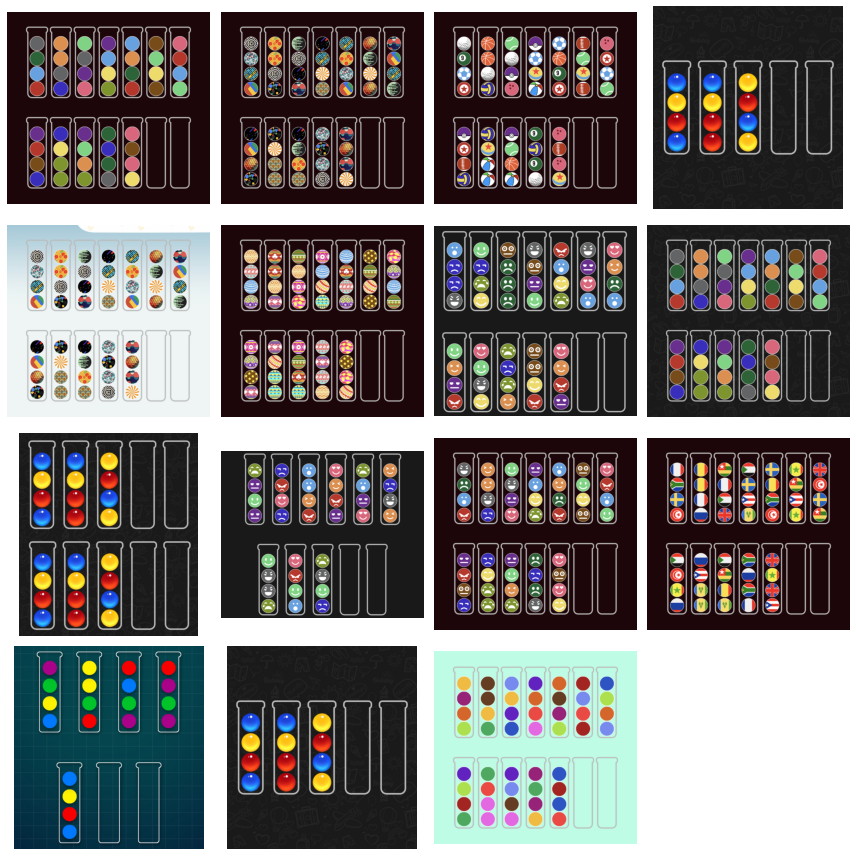

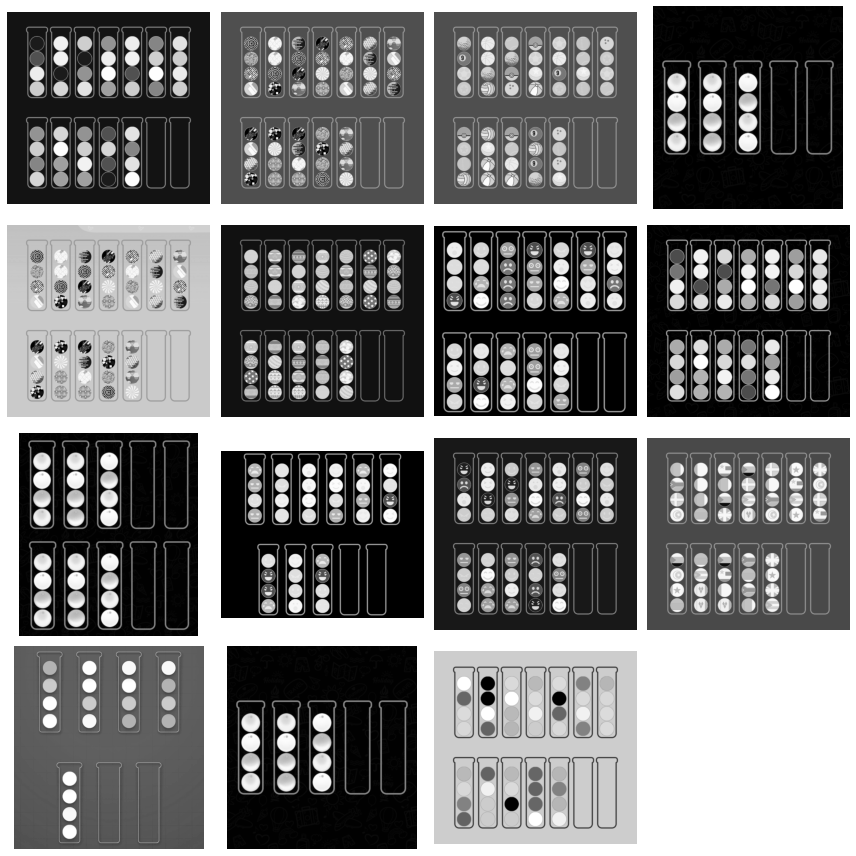

In [12]:
plot_all(img_cropped,fig_ratio=(3,3))
plot_all(img_hsv_gray)

## Edge based segmentation

### Applying Sobel Filter

In [13]:
img_edges = [
    filters.sobel(image) 
    for image in img_hsv_gray
]

### Edge binarizing

In [14]:
img_edges_bin  = [
    ((image>.03)).astype(np.uint8)
    for image in img_edges
]

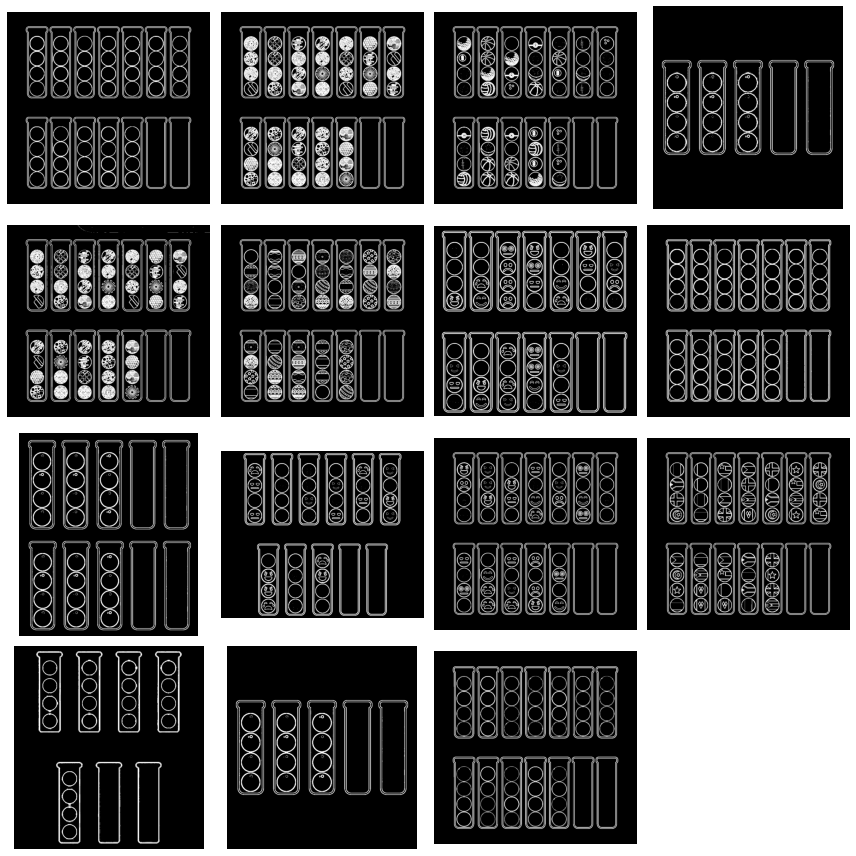

In [15]:
plot_all(img_edges_bin)

In [16]:
import pandas as pd

In [17]:
from sklearn.cluster import k_means

In [18]:
img_edges_canny = [
    feature.canny(image,.01) 
    for image in img_hsv_gray
]

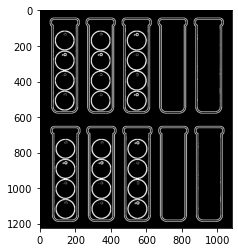

In [19]:
image = img_edges_bin[8]
# img = ndimage.binary_closing(img,morphology.square(1),5)
plt.imshow(image,cmap="gray")
df = pd.DataFrame(measure.regionprops_table(
    measure.label(image),
    properties=(
        "convex_area","major_axis_length","minor_axis_length",
        "bbox","image"
    )
))
df["max_axis_length"] = df[["major_axis_length","minor_axis_length"]].max(axis=1)
df=df[df["max_axis_length"]<image.shape[1]//2]

In [20]:
# Using KMeans to cluster the regions based on size 
# to get the clusters of tubes, balls and other small regions
centers, clusters, _ = k_means(df[["convex_area"]],3)
print(centers)
# getting tubes regions and ball regions by 
# sorting the cluster by size
b,t = np.argsort(centers[:,0].squeeze())[-2:]
b,t

[[   33.13375796]
 [ 9965.33333333]
 [22438.5       ]]


(1, 2)

In [322]:
bbox_columns = [f"bbox-{i}" for i in range(4)]
df["bbox"] = df[bbox_columns].apply(tuple,axis=1)
df.drop(bbox_columns,axis=1,inplace=True)
# df["centroid"] = df[centroid_columns].apply(tuple,axis=1)
# centroid_columns = [f"centroid-{i}" for i in range(2)]
# df.drop(centroid_columns,axis=1,inplace=True)

In [323]:
from skimage import draw

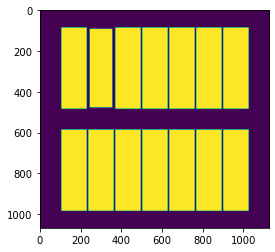

In [324]:
tube_image = np.zeros_like(img)
for i,(bbox,) in df[["bbox"]][clusters==t].iterrows():
    y1,x1,y2,x2 = bbox
    h,w = y2-y1,x2-x1
    rh,rw = h//2,w//2
    y,x = y1+rh,x1+rw
    tube_image[y1:y2,x1:x2] = 1
#     ball_image[y1:y2,x1:x2] = morphology.convex_hull_image(image)
#     ball_image[y1:y2,x1:x2] = ndimage.binary_fill_holes(image)    
#     ball_image[draw.disk((y,x),r)  ] = 1
plt.imshow(tube_image)

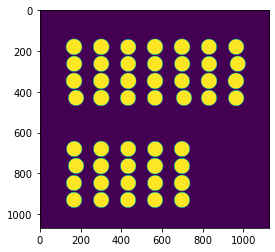

In [325]:
ball_image = np.zeros_like(img)
for i,(bbox,image) in df[["bbox","image"]][clusters==b].iterrows():
    y1,x1,y2,x2 = bbox
    h,w = y2-y1,x2-x1
    rh,rw = h//2,w//2
    y,x = y1+rh,x1+rw
#     ball_image[y1:y2,x1:x2] = 1
#     ball_image[y1:y2,x1:x2] = morphology.convex_hull_image(image)
#     ball_image[y1:y2,x1:x2] = ndimage.binary_fill_holes(image)    
    ball_image[draw.disk((y,x),rh,shape=img.shape)] = 1
plt.imshow(ball_image)

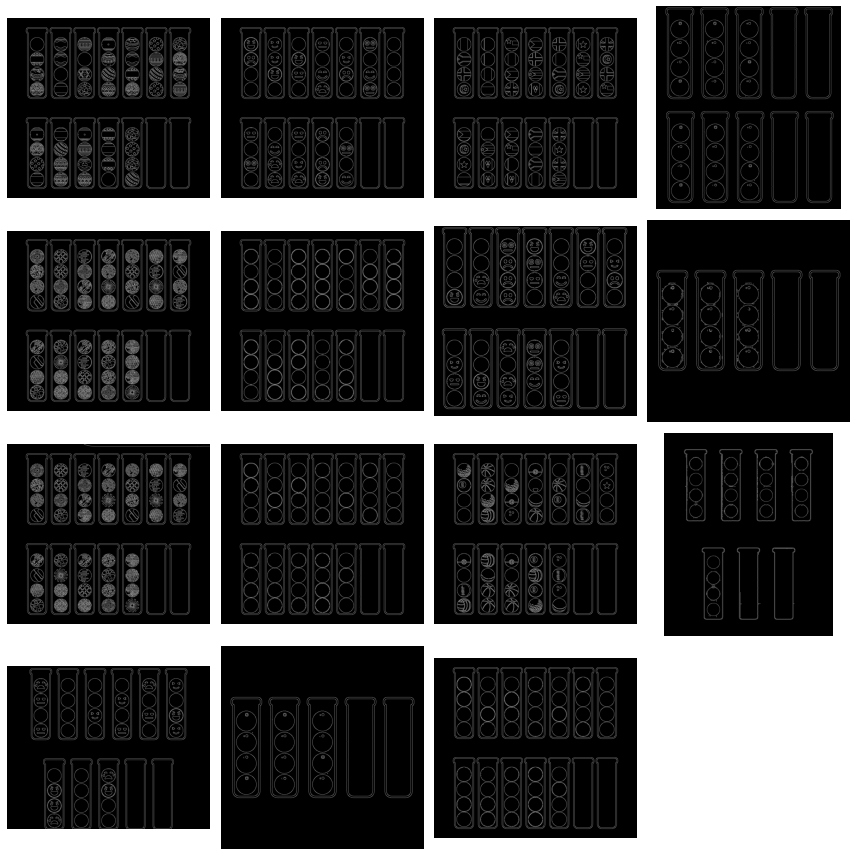

In [194]:
plot_all(img_edges_canny)

## Workaround for balls containting patterns

### Region Related utility funcs

In [327]:
from functools import partial

In [331]:
def height(region_mask):
    return region_mask.shape[0]
def width(region_mask):
    return region_mask.shape[0]

edge_regions,edge_labels = zip(*map(partial(image_regions,return_labels=True,extra_properties=(height,width)),img_edges_bin))

def ball_region_filter(region,image):
    rh = region.bbox[2] - region.bbox[0]
    rw = region.bbox[3] - region.bbox[1]
    h = image.shape[0]
    return h//20<rh<h//4 and h//20<rw<h//4

edge_regions_filtered = [
    [region for region in regions if ball_region_filter(region,image)]
    for regions,image in zip(edge_regions,img_edges_bin)
]
selem = ndimage.generate_binary_structure(2,1)
edge_filtered = [
    apply_regionwise(
        morphology.convex_hull_image,
        mask_from_regions(image,regions),
        regions
    )    
    for image,regions in zip(img_edges_bin,edge_regions_filtered)
]
plot_all(edge_filtered)

NameError: name 'image_regions' is not defined

### Inverting edges and performing Erosion to get internal regions

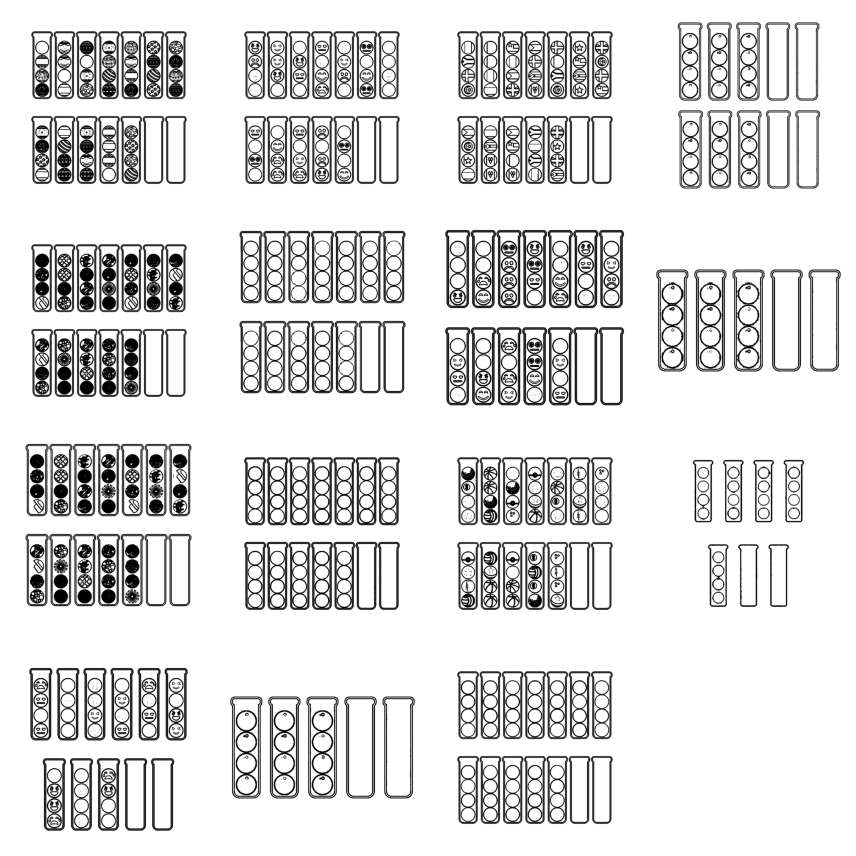

In [57]:
img_edges_inverted = [
    morphology.binary_erosion(1-image,ndimage.generate_binary_structure(2,1))
    for image in img_edges_bin
]
plot_all(img_edges_inverted)

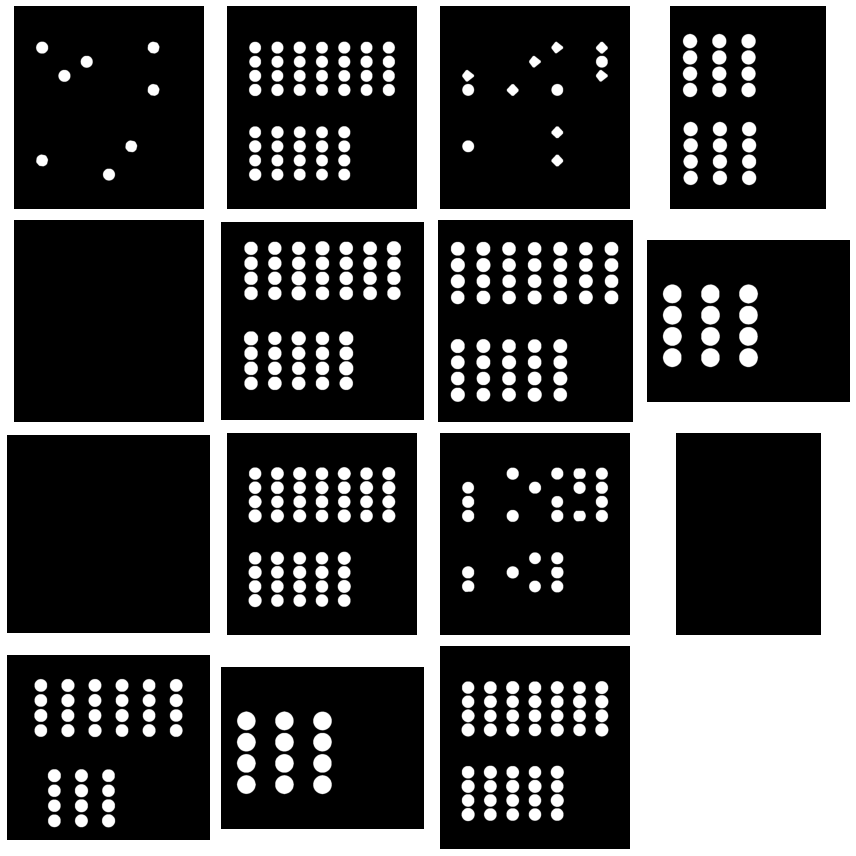

In [58]:
inv_edge_regions,inv_edge_labels = zip(*map(partial(get_regions,return_labels=True),img_edges_inverted))

inv_edge_regions_filtered = [
    [region for region in regions if ball_region_filter(region,image)]
    for regions,image in zip(inv_edge_regions,img_edges_inverted)
]

inv_edge_filtered = [
     apply_regionwise(
        morphology.convex_hull_image,
        mask_from_regions(image,regions),
        regions
    ) 
    for image, regions in zip(img_edges_inverted,inv_edge_regions_filtered)
]
plot_all(inv_edge_filtered)

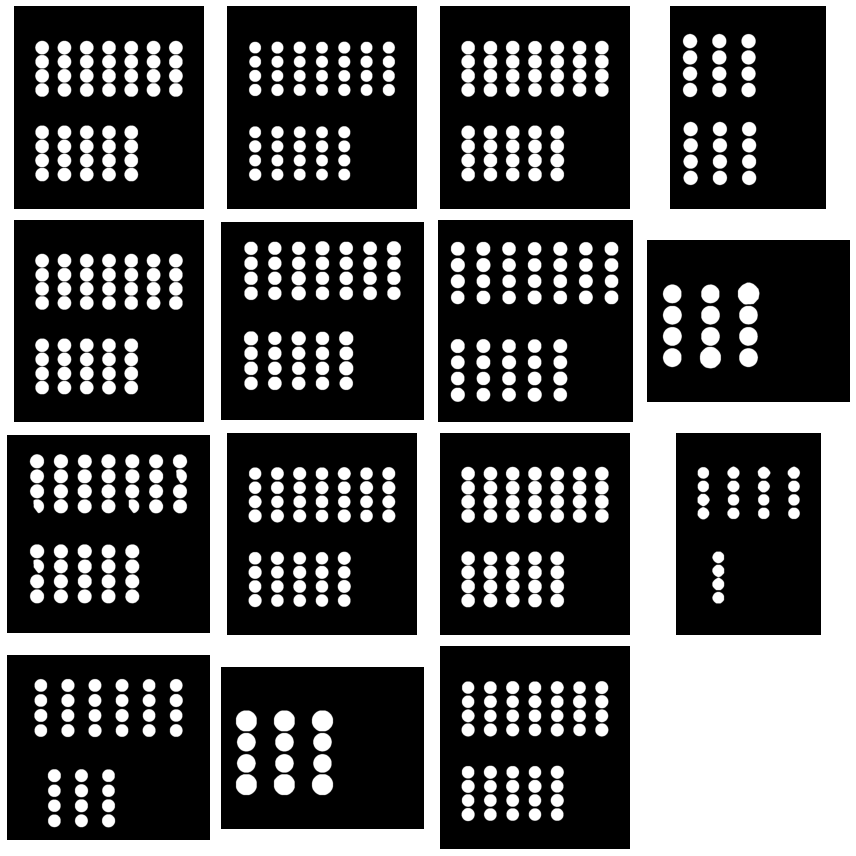

In [59]:
def combine_regions(edge_region,inv_edge_region):
    prod = edge_region * inv_edge_region
    if np.mean(prod)>.1:
        return prod
    return np.logical_or(edge_region,inv_edge_region)

img_edge_filtered_combined = [  combine_regions(image,inv_image) for image, inv_image in zip(edge_filtered,inv_edge_filtered)]
plot_all(img_edge_filtered_combined)

In [332]:
img_tubes= [ 
    morphology.binary_opening(
        ndimage.binary_fill_holes(
            image    
        ),
        morphology.disk(5)
    ).astype(np.uint8)
    for image in img_edges_bin
]
img_edges_bin  = [edge_img*edge_cleared  for edge_img,edge_cleared in zip(img_edges_bin,img_tubes)]

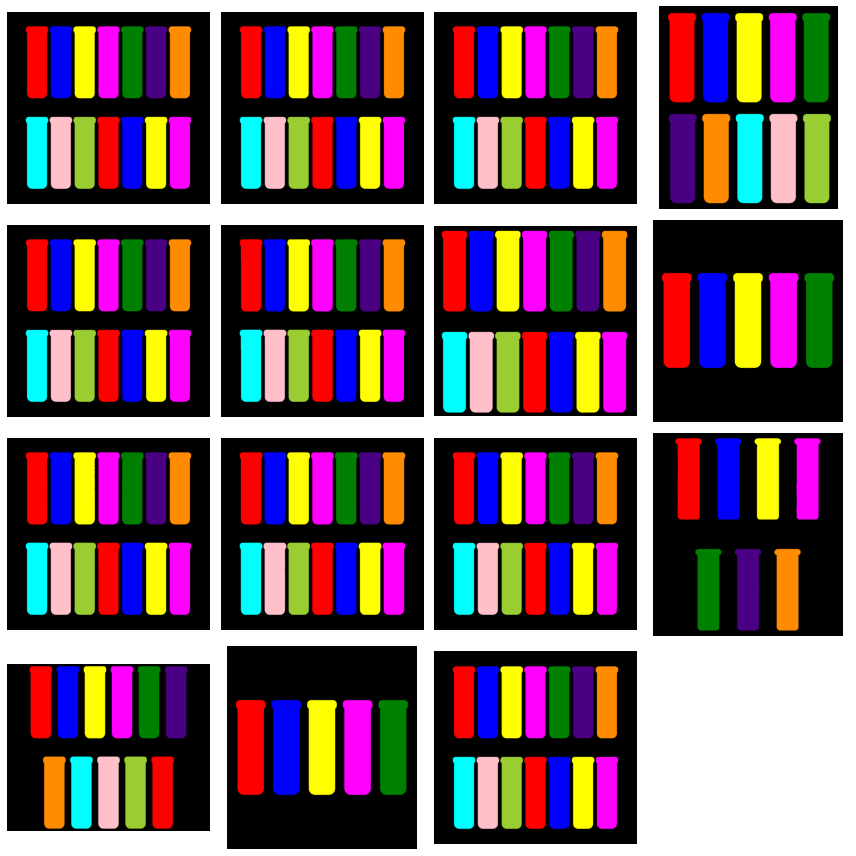

In [334]:
plot_all([color.label2rgb(measure.label(image),bg_label=0) for image in img_tubes])

## Finding Unique balls

In [31]:
img_balls = img_edge_filtered_combined
all_ball_regions = [get_regions(image,intensity_image=intensity_image) for image,intensity_image in zip(img_balls,img_cropped)]

In [32]:
from sklearn.cluster import KMeans

In [34]:
def get_ball_features(image):
    image = transform.resize(image,(32,32))
    h,v = 4,4
    return reduce_to_size(image,(h,v),np.mean)[:h,:v,...].flatten()
    return image.flatten()

ball_features = [
    np.array(
        [
            np.array(get_ball_features(region.intensity_image.copy()))
            for region in regions
        ]
    ) 
    for regions in all_ball_regions
]
print(ball_features[0].shape)

(48, 16)


In [35]:
def get_model(X):
    m = X.shape[0]
    k = m//4
    model  = KMeans(k).fit(X)
    return model

img_models = [get_model(X) for X in ball_features]
ball_labels = [model.labels_ for model in img_models]

[12, 12, 12, 6, 12, 12, 12, 3, 12, 12, 12, 5, 9, 3, 12]
[12, 12, 12, 6, 12, 12, 12, 3, 12, 12, 12, 5, 9, 3, 12]


In [36]:
from skimage.color import hsv2rgb

In [37]:
colors = np.array([
    [255, 0, 0],
    [255, 135, 0],
    [255, 211, 0],
    [222, 255, 10],
    [161, 255, 10],
    [10, 255, 153],
    [10, 239, 255],
    [20, 125, 245],
    [88, 10, 255],
    [190, 10, 255],
    [11, 57, 84],
    [8, 126, 139],
    [191, 215, 234],
    [255, 90, 95],
    [200, 29, 37]
    
])/255
np.random.shuffle(colors)

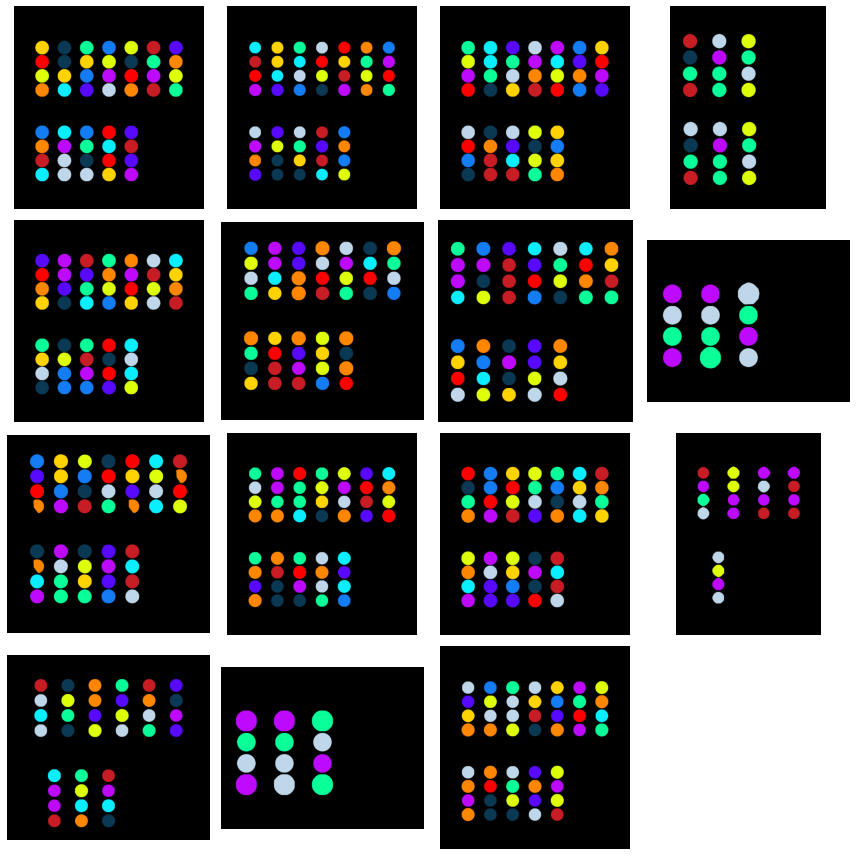

In [38]:
img_ball_labels = [image.astype(np.uint8) for image in img_balls]
for regions,image,labels in zip(all_ball_regions,img_ball_labels,ball_labels):
    for region,label in zip(regions,labels):
        image[region.slice][region.image] = label+1
plot_all([label2rgb(image,bg_label=0,colors=colors) for image in img_ball_labels])    

#  Functional implementation

In [ ]:
def get_color_codes(file,):
    image = util.img_as_ubyte(image)
    image_gray = util.img_as_ubyte(rgb2gray(image))
    v_margins = find_approx_tube_vertical_margins(image,20)
    image_cropped = image[v_margins]
    img_hsv_cropped = rgb2hsv(image_cropped)
    img_hsv_gray_cropped = util.img_as_ubtye(image_hsv_cropped[...,1:].dot([.25,.75]))
    img_edges = filters.sobel(img_hsv_gray_cropped)
    img_edges_bin = util.img_as_ubtye(image>.03)
    
    def height(region_mask):
        return region_mask.shape[0]
    def width(region_mask):
        return region_mask.shape[0]
    
    edge_regions,edge_labels = img_utils.get_regions(
        img_edges_bin,
        return_labels=True,
        extra_properties=(height,width)
    )
    
    h,w = img_edges_bin .shape
    
    def ball_region_filter(region):
        rh,rw = region.height,region.width
        return h//20<rh<h//4 and h//20<rw<h//4
    
    ball_regions = list(filter(ball_regions_filter,edge_regions))
    balls_filtered = img_utils.apply_regionwise(
        morphology.convex_hull_image,
        mask_from_regions(img_edges_bin,ball_regions)
        ball_regions
    )    
    
    img_edges_inverted = morphology.binary_erosion(
        1-img_edges_bin,
        ndimage.generate_binary_structure(2,1)
    )
    inv_edge_regions,inv_edge_labels = get_regions(
        img_edges_inverted,
        return_labels=True
    )

    inv_ball_regions = list(filter(ball_regions_filter,inv_edge_regions))

    inv_balls_filtered = apply_regionwise(
        morphology.convex_hull_image,
        mask_from_regions(img_edges_inverted,inv_ball_regions),
        inv_ball_regions
    ) 
    
    def combine_regions(edge_region,inv_edge_region):
        prod = edge_region * inv_edge_region
        if np.mean(prod)>.1:
            return prod
        return np.logical_or(edge_region,inv_edge_region)

    img_balls= combine_regions(balls_filtered,inv_balls_filtered)
    img_tubes= morphology.binary_opening(
        ndimage.binary_fill_holes(
            img_balls_filtered_combined
        ),
        morphology.disk(5)
    ).astype(np.uint8)
    
    img_ball_regions  = img_utils.get_regions(img_balls,intensity_image=img_cropped)
    
    def get_ball_features(image):
        image = transform.resize(image,(32,32))
        h,v = 4,4
        return reduce_to_size(image,(h,v),np.mean)[:h,:v,...].flatten()
        return image.flatten()

    ball_features = np.array([
        np.array(get_ball_features(region.intensity_image.copy()))
        for region in regions
    ]) 
    
    def get_model(X):
        m = X.shape[0]
        k = m//4
        model  = KMeans(k).fit(X)
        return model

    img_model= get_model(ball_features)
    ball_labels = img_model.labels_ +1 # Kmeans labels starts from 0
    
    img_ball_labels = util.img_as_ubtye(img_balls)
    
    for region,label in zip(ball_regiosn,ball_labels):
        img_ball_labels[region.slice][region.image] = label
    
    tube_regions = get_regions(tube_labels)
    ball_codes = [
        reversed(list(map(
            lambda x: x.label, 
            measure.regionprops(ball_labels[region.slice])
        )))# region props get labels from top to bottom
        for region in tube_regions
    ]
    return ball_codes
    

# GMM Based Foreground Seperaton

In [53]:
from sklearn.mixture import GaussianMixture as GMM

In [54]:
img_hsv_tweeked = [
    np.hstack([
        hsv_dot.reshape(-1,1),image.reshape(-1,3),
    ]).reshape(*image.shape[:2],4)
    for hsv_dot,image in zip(img_hsv_gray,img)                  
]

In [55]:
from sklearn.decomposition import PCA

In [ ]:
r_dim = 3 # dimension after reduction
img_tweeked_reduced = [
    PCA(r_dim).fit_transform(image.reshape(-1,4)).reshape(*image.shape[:2],r_dim) 
    for image in img_hsv_tweeked
]

In [ ]:
models = [GMM(2,random_state=7,reg_covar=10) for _ in range(len(img))]
gaussian_img_bin = [
    model.fit_predict(
        image.reshape(-1,r_dim)
    ).reshape(image.shape[:2]) 
    for model,image in zip(models,img_tweeked_reduced)
]

In [ ]:
# To invert if needed
for i  in range(len(gaussian_img_bin)):
    if np.mean(gaussian_img_bin[i])>.5:
        gaussian_img_bin[i] = 1-gaussian_img_bin[i]
        

In [ ]:
plot_all(gaussian_img_bin)

In [ ]:
# margins = [find_approx_tube_vertical_margins(image,70) for image in gaussian_img_bin]
img_foreground = [image[margin] for image,margin in zip(img,margins)]
img_foreground_cropped = [image[margin] for image,margin in zip(gaussian_img_bin,margins)]
plot_all(img_cropped)
plot_all(img_foreground_cropped)

In [ ]:
def solidity_check(region):
    test = region.image.copy()
    
    return region.solidity>.9

gaussian_balls = [
    apply_regionwise(
        partial(ndimage.binary_erosion,structure = ndimage.generate_binary_structure(2,1),iterations=7),image,
        condition=solidity_check
        )
    for tubes,image in zip(img_tubes, img_foreground_cropped)
]
plot_all(gaussian_balls)

In [ ]:
conditional_erosion()
gaussian_balls = [
    apply_regionwise(morphology.convex_hull_image,image)
    for image in gaussian_balls 
]
plot_all(gaussian_balls)

In [ ]:
def remove_small_objects(image,min_size):
    return (morphology.remove_small_objects(morphology.label(image),min_size)>0)

In [ ]:
big_objects = [remove_small_objects(image,4000) for image in img_balls]
img_small_balls = [
    ndimage.binary_closing(
        image^big_object,
        iterations=20,
        structure = morphology.disk(1),
        # mask = 1 - big_object,    
        ) 
    for big_object,image in zip(big_objects,img_balls)
]

In [ ]:
s_no = 12
test_image = img_balls[s_no].copy()
test_image_labels = morphology.label(test_image)
test_regions = measure.regionprops(test_image_labels)
max_area = np.max([region.filled_area for region in test_regions])
small_regions = [region for region in test_regions if region.filled_area<max_area-1000]
for region in small_regions:
    test_image[region.slice] = 0
plt.imshow(test_image ,cmap="gray")

In [ ]:
img_balls_corrected = [img|img_small for img,img_small in zip(img_balls,img_small_balls)]
plot_all(img_balls_corrected)

In [ ]:
 img_ball_labels = [
        
    morphology.label(image)
            
    for image in img_balls_corrected
]
plot_all([label2rgb(image,bg_label = 0 ) for image in img_ball_labels])